In [1]:
! pip install spacy

In [2]:
! spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     |████████████████████████████████| 13.9 MB 2.6 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import re
import nltk
from time import time
import tqdm
nltk.download('wordnet')  
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import spacy

# from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv
from lightgbm import LGBMClassifier

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')
import time

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
toxic_comments = pd.read_csv('/datasets/toxic_comments.csv')
df = toxic_comments.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [6]:
df.sample(10)

,Unnamed: 0,text,toxic
33496,33536,Getting additional opinions does seem like a b...,0
135984,136122,"""\nOn 17 April, 2007, Did you know? was update...",0
9637,9650,Vandalism Removed \nI have undid your edit to ...,0
42659,42709,"""==Live To Win==\nThe tie-in with the song is ...",0
40102,40152,Pictures were taken from the Greek Ministry of...,0
157948,158107,What is the device used for stiring contents o...,0
37887,37933,The opinnion of the predeeding ost represents ...,0
147120,147276,Good to read your reply. I re-checked the tal...,0
64993,65060,Are you serious? \n\nHow is calling someone a ...,0
33786,33826,Make up and spandex are,0


In [7]:
df['toxic'].value_counts(normalize =True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

классы несбалансированы, поэтому необходимо применить балансировку

In [8]:
from tqdm import trange, tqdm

df = df[['text','toxic']]
corpus = df['text'].values
 
def get_wordnet_pos(text):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([text])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)
 
def clear_text(text):
    cl_text = re.sub(r"[^a-zA-Z' ]", " ", text)
    clear_list = cl_text.split()
    clear_text = ' '.join(clear_list)
    return clear_text
 
wnl = WordNetLemmatizer()
def lemmatize(text):
    #lemm_list = [wnl.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)] 
    lemm_list = [wnl.lemmatize(w) for w in nltk.word_tokenize(text)] 
    lemm_text = " ".join(lemm_list)
    return lemm_text
 
lemm=[]
for i in tqdm(range(len(corpus))):
    lemm.append(lemmatize(clear_text(corpus[i])))

df['lemm_text']=pd.Series(lemm, index=df.index)

100%|██████████| 159292/159292 [01:21<00:00, 1958.80it/s]


In [15]:
# %%time
# df['lemm_text'] = df['text'].apply(lemmatize_text1)
corpus = df['lemm_text'].values

In [16]:
corpus[:3]

array(["Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They were n't vandalism just closure on some GAs after I voted at New York Dolls FAC And please do n't remove the template from the talk page since I 'm retired now",
       "D'aww He match this background colour I 'm seemingly stuck with Thanks talk January UTC",
       "Hey man I 'm really not trying to edit war It 's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page He seems to care more about the formatting than the actual info"],
      dtype=object)

** Сделал 2 способами **

In [8]:
%%time
#  Добавил лематизацию методом  spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatize_text(text):
    text = text.lower()
    doc = nlp(text)
    lemm_text = " ".join([token.lemma_ for token in doc])
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text) 
    return " ".join(cleared_text.split())

CPU times: user 531 ms, sys: 36 ms, total: 567 ms
Wall time: 749 ms


In [11]:
%%time
tqdm.pandas()
df['lemm_text'] = df['text'].progress_apply(lemmatize_text)
# corpus = df['lemm_text'].values

100%|██████████| 159292/159292 [21:16<00:00, 124.80it/s] 

CPU times: user 20min 21s, sys: 12.5 s, total: 20min 34s
Wall time: 21min 16s


In [13]:
df.head()

,Unnamed: 0,text,toxic,lemm_text
0,0,Explanation\nWhy the edits made under my usern...,0,explanation why the edit make under my usernam...
1,1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour I be see...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man I be really not try to edit war it be ...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,more I can not make any real suggestion on imp...
4,4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


Разобьем на выборки

In [12]:
features = corpus
target = df['toxic'].values

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [13]:
stop_words = set(stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words = stop_words)
X_train = count_tf_idf.fit_transform(X_train)

In [14]:
X_test = count_tf_idf.transform(X_test)

[Пайплайн](https://www.helenkapatsa.ru/paiplain/)<br> дополнительная опция

In [15]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.naive_bayes import ComplementNB
# from sklearn.pipeline import Pipeline

# pipeline = Pipeline(
#     [
#         ("vect", TfidfVectorizer()),
#         ("clf", ComplementNB()),
#     ]
# )
# pipeline

Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', ComplementNB())])

In [16]:
# parameter_grid = {
#     "vect__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
# #     "vect__min_df": (1, 3, 5, 10),
# #     "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
# #     "vect__norm": ("l1", "l2"),
#     "clf__alpha": np.logspace(-6, 6, 13),
# }

In [17]:
# from pprint import pprint
# from sklearn.model_selection import RandomizedSearchCV

# random_search = RandomizedSearchCV(
#     estimator=pipeline,
#     param_distributions=parameter_grid,
#     n_iter=40,
#     random_state=0,
#     n_jobs=2,
#     verbose=1,
# )

# print("Performing grid search...")
# print("Hyperparameters to be evaluated:")
# pprint(parameter_grid)

Performing grid search...
Hyperparameters to be evaluated:
{'clf__alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
 'vect__max_df': (0.2, 0.4, 0.6, 0.8, 1.0),
 'vect__min_df': (1, 3, 5, 10),
 'vect__ngram_range': ((1, 1), (1, 2)),
 'vect__norm': ('l1', 'l2')}


In [19]:
# # t0 = time()
# random_search.fit(X_train, y_train)
# # print(f"Done in {time() - t0:.3f}s")

In [20]:
# print("Best parameters combination found:")
# best_parameters = random_search.best_estimator_.get_params()
# for param_name in sorted(parameter_grid.keys()):
#     print(f"{param_name}: {best_parameters[param_name]}")

## Обучение

In [23]:
%%time
#LogisticRegression
lr_model = LogisticRegression()
hyperparams = [{'C':[10],   
                'class_weight':['balanced']}]
lrcv = GridSearchCV(lr_model, hyperparams, scoring='f1',cv=3)
lrcv.fit(X_train, y_train)
lr_best_params = lrcv.best_params_

print("Лучшие параметры модели:")
print(lr_best_params)
print('F1:', lrcv.best_score_)

Лучшие параметры модели:
{'C': 10, 'class_weight': 'balanced'}
F1: 0.7686488549827536
CPU times: user 54.6 s, sys: 1min 57s, total: 2min 52s
Wall time: 2min 53s


In [30]:
%%time
#CatBoost
cat = CatBoostClassifier(eval_metric="F1", 
                                   iterations=100, 
                                   max_depth=6, 
                                   learning_rate=0.9, 
                                   random_state=42
                                   )
# text_features=["text_lemm"]

CPU times: user 42 µs, sys: 34 µs, total: 76 µs
Wall time: 80.1 µs


In [31]:

cvf1 = cross_val_score(cat, X_train, y_train, cv=3, scoring="f1", verbose=20)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
0:	learn: 0.4270639	total: 2.52s	remaining: 4m 9s
1:	learn: 0.5762580	total: 4.36s	remaining: 3m 33s
2:	learn: 0.6136415	total: 6.24s	remaining: 3m 21s
3:	learn: 0.6385088	total: 8.1s	remaining: 3m 14s
4:	learn: 0.6612109	total: 9.89s	remaining: 3m 7s
5:	learn: 0.6641965	total: 11.7s	remaining: 3m 3s
6:	learn: 0.6733842	total: 13.6s	remaining: 3m
7:	learn: 0.6864191	total: 15.3s	remaining: 2m 56s
8:	learn: 0.6937566	total: 17.1s	remaining: 2m 52s
9:	learn: 0.7004467	total: 18.9s	remaining: 2m 50s
10:	learn: 0.7062418	total: 20.8s	remaining: 2m 48s
11:	learn: 0.7103825	total: 22.6s	remaining: 2m 45s
12:	learn: 0.7211229	total: 24.5s	remaining: 2m 43s
13:	learn: 0.7226718	total: 26.3s	remaining: 2m 41s
14:	learn: 0.7268756	total: 28.1s	remaining: 2m 39s
15:	learn: 0.7278229	total: 29.9s	remaining: 2m 37s
16:	learn: 0.7304396	total: 31.8s	remaining: 2m 35s
17:	learn: 0.7386062	total: 33.5s	remaining: 2m 32s
1

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.5min remaining:    0.0s


0:	learn: 0.4198020	total: 2.53s	remaining: 4m 10s
1:	learn: 0.5711645	total: 4.53s	remaining: 3m 41s
2:	learn: 0.5977559	total: 6.45s	remaining: 3m 28s
3:	learn: 0.6170752	total: 8.38s	remaining: 3m 21s
4:	learn: 0.6440854	total: 10.3s	remaining: 3m 15s
5:	learn: 0.6409272	total: 12.3s	remaining: 3m 12s
6:	learn: 0.6574736	total: 14.3s	remaining: 3m 9s
7:	learn: 0.6672531	total: 16.2s	remaining: 3m 6s
8:	learn: 0.6801567	total: 18.1s	remaining: 3m 3s
9:	learn: 0.6943909	total: 20.1s	remaining: 3m
10:	learn: 0.6994605	total: 22s	remaining: 2m 57s
11:	learn: 0.7057163	total: 23.9s	remaining: 2m 55s
12:	learn: 0.7127273	total: 25.8s	remaining: 2m 52s
13:	learn: 0.7164948	total: 27.7s	remaining: 2m 50s
14:	learn: 0.7206545	total: 29.6s	remaining: 2m 47s
15:	learn: 0.7242713	total: 31.5s	remaining: 2m 45s
16:	learn: 0.7282482	total: 33.3s	remaining: 2m 42s
17:	learn: 0.7321220	total: 35.1s	remaining: 2m 39s
18:	learn: 0.7328307	total: 36.9s	remaining: 2m 37s
19:	learn: 0.7364108	total: 38.

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.0min remaining:    0.0s


0:	learn: 0.3595018	total: 2.46s	remaining: 4m 3s
1:	learn: 0.5425232	total: 4.45s	remaining: 3m 38s
2:	learn: 0.5977134	total: 6.4s	remaining: 3m 26s
3:	learn: 0.6265686	total: 8.25s	remaining: 3m 18s
4:	learn: 0.6521645	total: 10.2s	remaining: 3m 13s
5:	learn: 0.6671891	total: 12.1s	remaining: 3m 8s
6:	learn: 0.6790185	total: 13.9s	remaining: 3m 4s
7:	learn: 0.6855941	total: 15.7s	remaining: 3m
8:	learn: 0.6940899	total: 17.5s	remaining: 2m 57s
9:	learn: 0.6941135	total: 19.4s	remaining: 2m 54s
10:	learn: 0.6945542	total: 21.2s	remaining: 2m 51s
11:	learn: 0.7014225	total: 23.1s	remaining: 2m 49s
12:	learn: 0.7037373	total: 25s	remaining: 2m 47s
13:	learn: 0.7099687	total: 26.9s	remaining: 2m 45s
14:	learn: 0.7156293	total: 28.7s	remaining: 2m 42s
15:	learn: 0.7211605	total: 30.6s	remaining: 2m 40s
16:	learn: 0.7231615	total: 32.4s	remaining: 2m 38s
17:	learn: 0.7257511	total: 34.2s	remaining: 2m 35s
18:	learn: 0.7291382	total: 36s	remaining: 2m 33s
19:	learn: 0.7320101	total: 37.8s	

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.4min finished


In [32]:
cat.best_score= cvf1.mean()
cat.best_score

0.743214087214533

In [33]:
cat.fit(X_train, y_train, verbose=20)
print('F1:', cat.best_score)

0:	learn: 0.4186967	total: 3.3s	remaining: 5m 26s
20:	learn: 0.7417861	total: 53.6s	remaining: 3m 21s
40:	learn: 0.7709492	total: 1m 41s	remaining: 2m 26s
60:	learn: 0.7928176	total: 2m 29s	remaining: 1m 35s
80:	learn: 0.8057885	total: 3m 17s	remaining: 46.4s
99:	learn: 0.8132157	total: 4m 3s	remaining: 0us
F1: 0.743214087214533


<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> 👍</font>

**Сначала был поиск лучших параметров. Он выполнялся 6 часов
Поэтому программу упростил**
<!-- # grid = {'learning_rate': [0.1, 0.2]}
# parameters = {'eval_metric': 'F1',
#               'random_seed':42,
#               'learning_rate': 0.01,
#                'early_stopping_rounds': 200,
#               'verbose':200}
# cv_dataset = Pool(data=X_train, label= y_train)    
# cat = CatBoostClassifier(**parameters)
# catcv = cat.grid_search(grid,cv_dataset, cv=4) -->

#CAT_best_params = cat.best_params_
#print("Лучшие параметры модели:")

**Результаты подбора лучших гиперпарамеиров**
0:	learn: 0.3587331	test: 0.3643288	best: 0.3643288 (0)	total: 2.96s	remaining: 49m 19s
200:	learn: 0.6023715	test: 0.5879505	best: 0.5879505 (197)	total: 7m 43s	remaining: 30m 42s
400:	learn: 0.6613216	test: 0.6479735	best: 0.6481387 (388)	total: 15m 1s	remaining: 22m 25s
600:	learn: 0.6947535	test: 0.6755886	best: 0.6760913 (593)	total: 22m 10s	remaining: 14m 43s
800:	learn: 0.7250473	test: 0.6967711	best: 0.6967711 (799)	total: 29m 13s	remaining: 7m 15s
999:	learn: 0.7384238	test: 0.7076332	best: 0.7079731 (997)	total: 36m 40s	remaining: 0us

bestTest = 0.7079731028
bestIteration = 997

0:	loss: 0.7079731	best: 0.7079731 (0)	total: 37m 37s	remaining: 1h 15m 15s
0:	learn: 0.3587331	test: 0.3643288	best: 0.3643288 (0)	total: 3.22s	remaining: 53m 38s
200:	learn: 0.7112386	test: 0.6859524	best: 0.6859524 (200)	total: 8m 19s	remaining: 33m 3s
400:	learn: 0.7593166	test: 0.7240244	best: 0.7241947 (398)	total: 16m 15s	remaining: 24m 17s
600:	learn: 0.7796266	test: 0.7381616	best: 0.7383329 (597)	total: 24m 18s	remaining: 16m 8s
800:	learn: 0.7983988	test: 0.7478181	best: 0.7478181 (799)	total: 31m 57s	remaining: 7m 56s
999:	learn: 0.8115399	test: 0.7491425	best: 0.7497143 (982)	total: 39m 23s	remaining: 0us

bestTest = 0.7497142857
bestIteration = 982

1:	loss: 0.7497143	best: 0.7497143 (1)	total: 1h 17m 1s	remaining: 38m 30s
0:	learn: 0.3587331	test: 0.3643288	best: 0.3643288 (0)	total: 3.37s	remaining: 56m 6s
200:	learn: 0.7619917	test: 0.7236749	best: 0.7236749 (200)	total: 8m 19s	remaining: 33m 4s
400:	learn: 0.7981325	test: 0.7425150	best: 0.7428045 (399)	total: 16m 1s	remaining: 23m 55s
600:	learn: 0.8206192	test: 0.7516011	best: 0.7525160 (577)	total: 23m 46s	remaining: 15m 47s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.752516011
bestIteration = 577

2:	loss: 0.7525160	best: 0.7525160 (2)	total: 1h 47m 22s	remaining: 0us
Estimating final quality...
Training on fold [0/3]
0:	learn: 0.4498744	test: 0.4459390	best: 0.4459390 (0)	total: 2.33s	remaining: 38m 48s
200:	learn: 0.7608921	test: 0.7285376	best: 0.7285376 (200)	total: 5m 54s	remaining: 23m 29s
400:	learn: 0.8020067	test: 0.7431843	best: 0.7440022 (390)	total: 11m 32s	remaining: 17m 15s
600:	learn: 0.8192676	test: 0.7473927	best: 0.7474611 (585)	total: 17m 19s	remaining: 11m 30s
800:	learn: 0.8302602	test: 0.7511105	best: 0.7511105 (793)	total: 23m 6s	remaining: 5m 44s
999:	learn: 0.8395367	test: 0.7549296	best: 0.7549296 (999)	total: 28m 29s	remaining: 0us

bestTest = 0.7549295775
bestIteration = 999

Training on fold [1/3]
0:	learn: 0.3699757	test: 0.3607297	best: 0.3607297 (0)	total: 2.51s	remaining: 41m 49s
200:	learn: 0.7600744	test: 0.7132240	best: 0.7148268 (197)	total: 5m 43s	remaining: 22m 43s
400:	learn: 0.8042638	test: 0.7346269	best: 0.7350848 (369)	total: 11m 17s	remaining: 16m 51s
600:	learn: 0.8211842	test: 0.7444880	best: 0.7446578 (595)	total: 16m 48s	remaining: 11m 9s
800:	learn: 0.8294249	test: 0.7471373	best: 0.7474747 (799)	total: 22m 20s	remaining: 5m 33s
999:	learn: 0.8407229	test: 0.7505696	best: 0.7506717 (934)	total: 28m 1s	remaining: 0us

bestTest = 0.7506716819
bestIteration = 934

Training on fold [2/3]
0:	learn: 0.4225833	test: 0.4276010	best: 0.4276010 (0)	total: 2.76s	remaining: 45m 55s
200:	learn: 0.7632664	test: 0.7189303	best: 0.7190188 (194)	total: 6m 1s	remaining: 23m 57s
400:	learn: 0.8063830	test: 0.7391304	best: 0.7391304 (400)	total: 12m 44s	remaining: 19m 2s
600:	learn: 0.8232433	test: 0.7421522	best: 0.7423641 (587)	total: 18m 50s	remaining: 12m 30s
800:	learn: 0.8337029	test: 0.7462199	best: 0.7462199 (799)	total: 25m 7s	remaining: 6m 14s
999:	learn: 0.8418728	test: 0.7478615	best: 0.7478615 (998)	total: 31m 18s	remaining: 0us

bestTest = 0.7478615071
bestIteration = 998

In [34]:
%%time
#LightGBM

LightGBM_model = LGBMClassifier()
hyperparams = [{'max_depth' : [1], # -1, 1
                'learning_rate':[0.3], 
                'n_estimators' : [100],  # 200
                'random_state':[42]}]
lgcv = GridSearchCV(LightGBM_model, hyperparams, scoring='f1',cv=2)
LightGBM_model.fit(X_train, y_train)

CPU times: user 2min 52s, sys: 0 ns, total: 2min 52s
Wall time: 2min 52s


LGBMClassifier()

In [35]:
lg_predict_train = LightGBM_model.predict(X_train)
lgcv.best_score = f1_score(y_train, lg_predict_train)

In [36]:
print('F1:', lgcv.best_score)

F1: 0.7774873828406631


## Выводы

In [37]:
lin_array =    [lrcv.best_score_]
cat_array  = [cat.best_score]
lg_array =    [lgcv.best_score]

rezult={'Линейная регрессия':np.array(lin_array), 'CatBoost':np.array(cat_array), 
        'LGBM':np.array(lg_array)}
rezult_df=pd.DataFrame(rezult,index=['F1'])
rezult_df

,Линейная регрессия,CatBoost,LGBM
F1,0.768649,0.743214,0.777487


<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Отлично, что есть табличка результатов для сравнения.</font>

Все модели имеют значение F1 соответствующее 75. Лучший результат показал а модель LightGBM model. Но у LogisticRegression меньше ложно отрицательных предсказаний, а также она отработала на порядок быстрее. 

Такрим образом, для бизнеса лучше подходит модель LogisticRegression

In [38]:
%%time
lr_model = LogisticRegression()
lr_model.set_params(**lr_best_params)
lr_model.fit(X_train, y_train)
predict_test = lr_model.predict(X_test)
f1 = f1_score(y_test, predict_test)
print('F1 регрессии:', f1)

F1 регрессии: 0.7715089589811935
CPU times: user 16.8 s, sys: 35.1 s, total: 51.9 s
Wall time: 52 s


<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>Тестирование проведено верно.</font>

Метрики LogisticRegression
ROC AUC: 0.967904302447184
F1: 0.7715089589811935
Precision: 0.7333896396396397
Recall: 0.8138081849422055
Accuracy: 0.9515678458206472



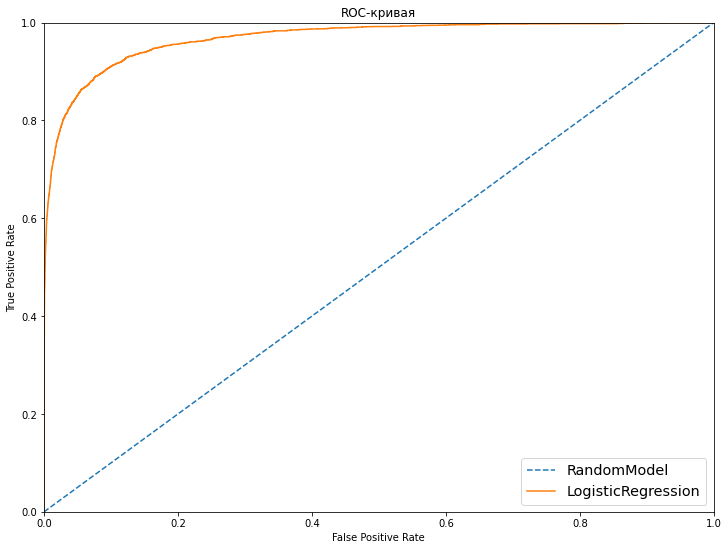

In [39]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


classificator = LogisticRegression()
classificator.set_params(**lr_best_params)
classificator.fit(X_train, y_train)
probabilities_test = classificator.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
predict_test = classificator.predict(X_test)
plt.plot(fpr, tpr, label='LogisticRegression')
print('Метрики LogisticRegression')
print('ROC AUC:', roc_auc_score(y_test, probabilities_one_test))
print('F1:', f1_score(y_test, predict_test))
print('Precision:', precision_score(y_test, predict_test))
print('Recall:', recall_score(y_test, predict_test))
print('Accuracy:', accuracy_score(y_test, predict_test))
print()

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

**Вывод**

 - Подготовленны данные обучения.
  - Cформированы обучающая и тестовая выборка.
  - Обучены модели и выбрана лучшая из них.
  - Проведено обучение на тестовых данных, F1 составил 0.77.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны